In [1]:
import json
import csv

In [2]:
cpsat_sol = []
with open('cpsat_solutions.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        cpsat_sol.append(row)

In [3]:
def compare_results(cpsat_infer):
    comparison_results = []
    for test_bench_id, test_result in cpsat_infer.items():
        row = 0
        while int(cpsat_sol[row][0]) != test_result['benchmark_id']:
            row += 1
        bench_row_start = row
        while int(cpsat_sol[row][3]) > test_result['feasibility_abs_makespan'] and \
            int(cpsat_sol[row][0]) == test_result['benchmark_id']:
            row += 1
        if row > bench_row_start and int(cpsat_sol[row][0]) == test_result['benchmark_id']:
            cpsat_same_quality_time = 0.5 * (float(cpsat_sol[row - 1][1]) + float(cpsat_sol[row][1]))
        else:
            cpsat_same_quality_time = float(cpsat_sol[row][1])
        infer_feasible_time = test_result['inference_time'] + test_result['feasibility_timing']
        comparison_results.append({
            'benchmark_id': test_result['benchmark_id'],
            'infer_feasible_time': infer_feasible_time,
            'cpsat_same_quality_time': cpsat_same_quality_time,
            'rel_time_savings_per': infer_feasible_time / cpsat_same_quality_time * 100.0
        })
    return comparison_results

### Unconstrained makespan case

In [4]:
# with open('inference-sgs_vs_cpsat.json', 'r') as jsonfile:
with open('allinstances_inference_vs_sgspostpro_20230222175440.json', 'r') as jsonfile:
    cpsat_infer = json.load(jsonfile)
    comparison_results = compare_results(cpsat_infer)

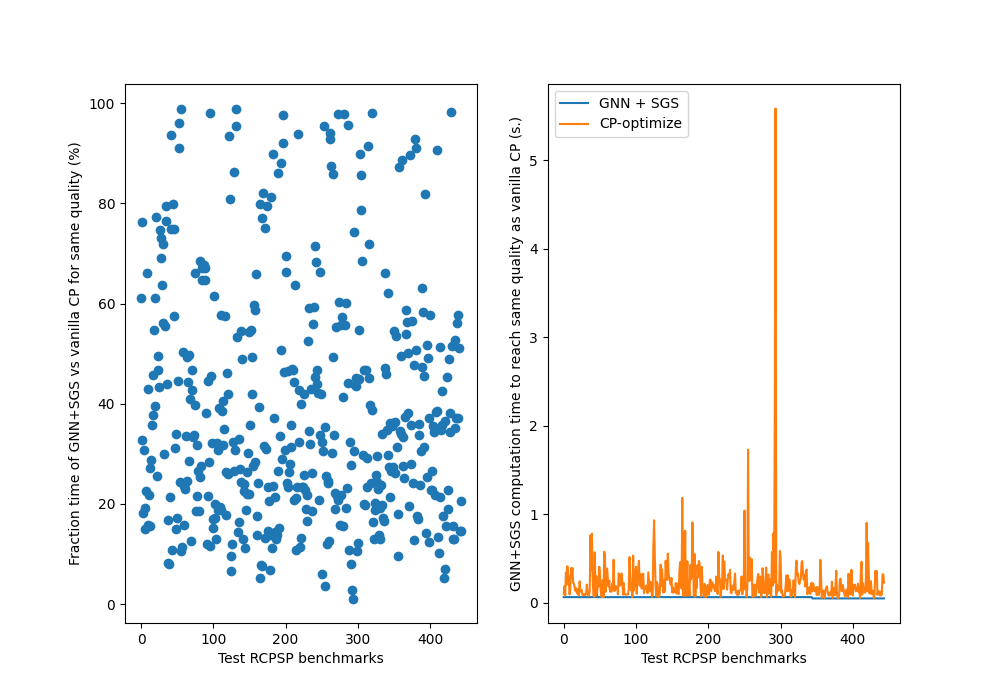

In [5]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget

rel_time_savings_gain = [res['rel_time_savings_per'] for res in comparison_results if res['rel_time_savings_per'] < 100.]
timings = [(res['infer_feasible_time'], res['cpsat_same_quality_time']) for res in comparison_results if res['rel_time_savings_per'] < 100.]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize =(10, 7))
ax1.set_xlabel('Test RCPSP benchmarks')
ax1.set_ylabel('Fraction time of GNN+SGS vs vanilla CP for same quality (%)')
ax1.scatter(x=np.arange(len(rel_time_savings_gain)), y=rel_time_savings_gain)
ax2.set_xlabel('Test RCPSP benchmarks')
ax2.set_ylabel('GNN+SGS computation time to reach same quality as vanilla CP (s.)')
ax2.plot(np.arange(len(rel_time_savings_gain)), [t[0] for t in timings], label='GNN + SGS')
ax2.plot(np.arange(len(rel_time_savings_gain)), [t[1] for t in timings], label='CP-optimize')
ax2.legend()
plt.show()

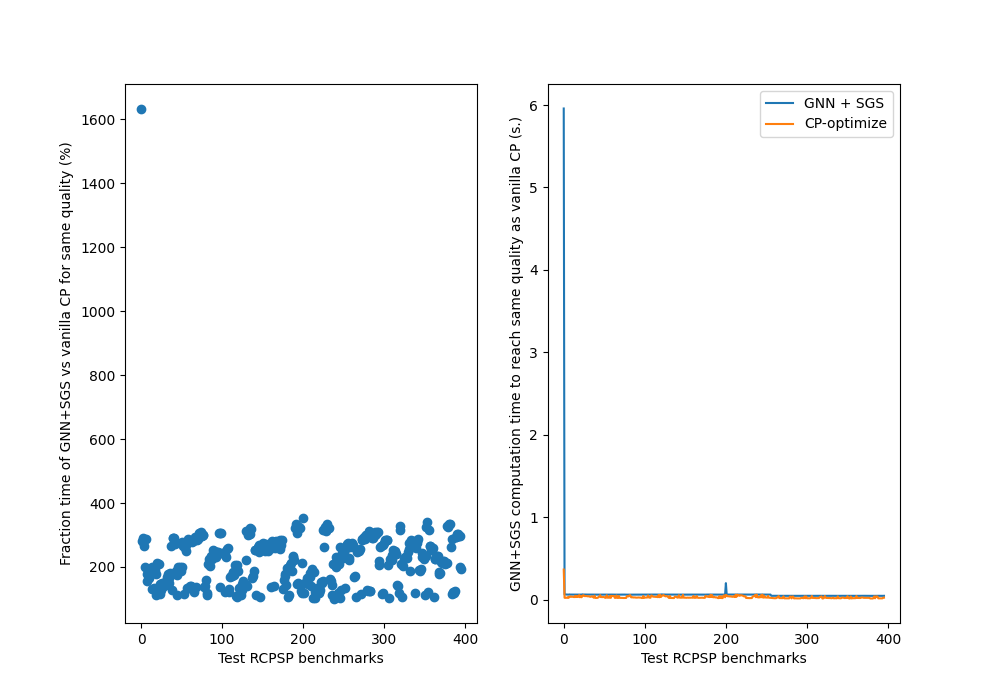

In [6]:
rel_time_savings_loss = [res['rel_time_savings_per'] for res in comparison_results if res['rel_time_savings_per'] >= 100.]
timings = [(res['infer_feasible_time'], res['cpsat_same_quality_time']) for res in comparison_results if res['rel_time_savings_per'] >= 100.]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize =(10, 7))
ax1.set_xlabel('Test RCPSP benchmarks')
ax1.set_ylabel('Fraction time of GNN+SGS vs vanilla CP for same quality (%)')
ax1.scatter(x=np.arange(len(rel_time_savings_loss)), y=rel_time_savings_loss)
ax2.set_xlabel('Test RCPSP benchmarks')
ax2.set_ylabel('GNN+SGS computation time to reach same quality as vanilla CP (s.)')
ax2.plot(np.arange(len(rel_time_savings_loss)), [t[0] for t in timings], label='GNN + SGS')
ax2.plot(np.arange(len(rel_time_savings_loss)), [t[1] for t in timings], label='CP-optimize')
ax2.legend()
plt.show()

In [7]:
len(rel_time_savings_gain) / len(comparison_results) * 100.

52.85714285714286

In [8]:
len(rel_time_savings_loss) / len(comparison_results) * 100.

47.14285714285714

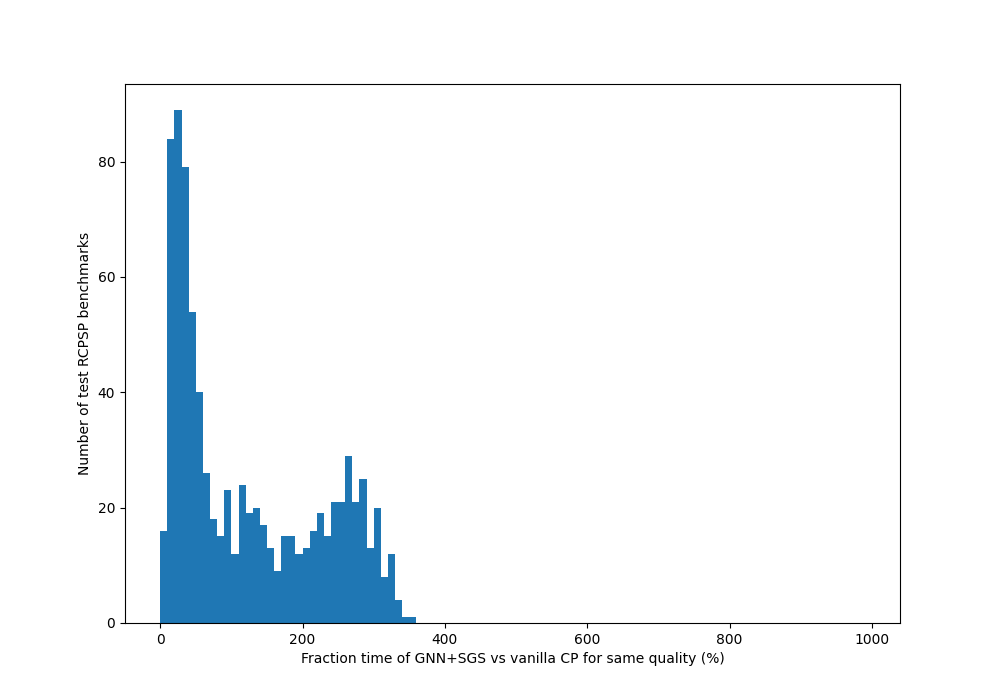

In [9]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(rel_time_savings_gain + rel_time_savings_loss, bins=np.arange(start=0, stop=1000, step=10))
ax.set_xlabel('Fraction time of GNN+SGS vs vanilla CP for same quality (%)')
ax.set_ylabel('Number of test RCPSP benchmarks')
plt.show()

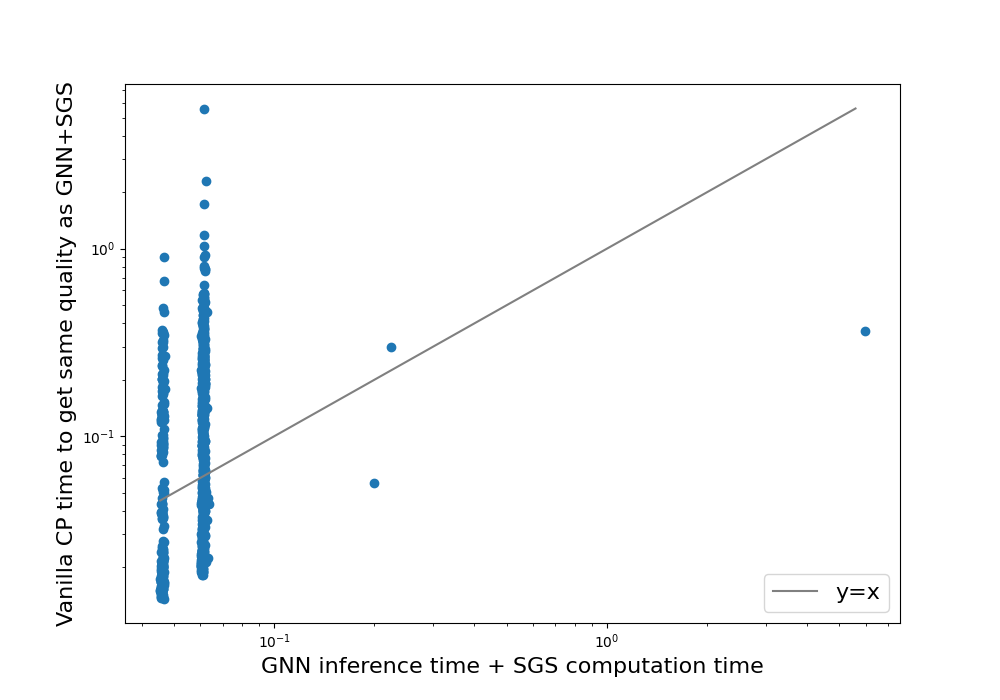

In [10]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.scatter(x=[cr['infer_feasible_time'] for cr in comparison_results], y=[cr['cpsat_same_quality_time'] for cr in comparison_results])
ax.set_xlabel('GNN inference time + SGS computation time', fontsize=16)
ax.set_ylabel('Vanilla CP time to get same quality as GNN+SGS', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
minv = max(min(cr['infer_feasible_time'] for cr in comparison_results), min(cr['cpsat_same_quality_time'] for cr in comparison_results))
maxv = min(max(cr['infer_feasible_time'] for cr in comparison_results), max(cr['cpsat_same_quality_time'] for cr in comparison_results))
line, = ax.plot([minv, maxv], [minv, maxv], color='gray')
line.set_label('y=x')
ax.legend(fontsize=16)
plt.show()